# **Brain Tumor Detection MRI**

### Carlos Barquero Gómez de la Venta

### Ricardo de Ruz Rodríguez

#### Importamos las librerías que vamos a utilizar

In [ ]:
import numpy as np
import pandas as pd

# For the Model
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from keras import backend as K
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from keras.models import load_model
import keras.metrics
from keras.models import save_model

# For Loading the Dataset, Preprocessing and Train-test Split
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import os
from skimage.color import rgb2gray
from skimage.feature import hog
from keras.preprocessing.image import ImageDataGenerator
import sys
from sklearn.preprocessing import MinMaxScaler
import joblib
from joblib import dump

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Evaluate
from keras.metrics import Precision, Recall
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# For Segmentation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage import io
from skimage.transform import resize
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

#### Nos conectamos a nuestro entorno de Google Drive donde tenemos los datos almacenados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Cargamos las etiquetas y la ruta donde se encuentran las imágenes de train y test

In [ ]:
# Lectura de la ruta
labels = ['glioma', 'meningioma', 'notumor', 'pituitary'] #Tipos de tumor que podemos encontrar en las imágenes
image_size = 150 #Tamaño de la imagen
train_folder_path = '/content/drive/MyDrive/MasterUE/TFM/archive/Training' #Ruta del conjunto de train
test_folder_path = '/content/drive/MyDrive/MasterUE/TFM/archive/Testing' #Ruta del conjunto de test

#### Carga de las imágenes

In [ ]:
# Carga del conjunto de entrenamiento
train_images = []
train_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(train_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        train_images.append(img)
        train_labels.append(i)

# Carga del dataset para utilizar en model.evaluate
test_images = []
test_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(test_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        test_images.append(img)
        test_labels.append(i)

# Convertir las imágenes y las etiquetas a NumPy arrays
X_train = np.array(train_images)
Y_train = np.array(train_labels)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

# Convertir las etiquetas a enteros
Y_test = Y_test.astype(int)
Y_test = Y_test.astype(int)

#shuffle conjunto de entrenamiento
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5712, 150, 150, 3)

#### Aplicamos One Hot Encoding a las etiquetas

In [ ]:
# Convertir etiquetas numéricas enteras a etiquetas categóricas codificadas en one-hot
Y_train_OHE = tf.keras.utils.to_categorical(Y_train, num_classes = len(labels))
Y_test_OHE = tf.keras.utils.to_categorical(Y_test, num_classes = len(labels))

#### Dimensiones de las imágenes

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5712, 150, 150, 3)
(1311, 150, 150, 3)
(5712,)
(1311,)


# **2. Análisis exploratorio de los datos**


### Proporción de datos en train, validación y test

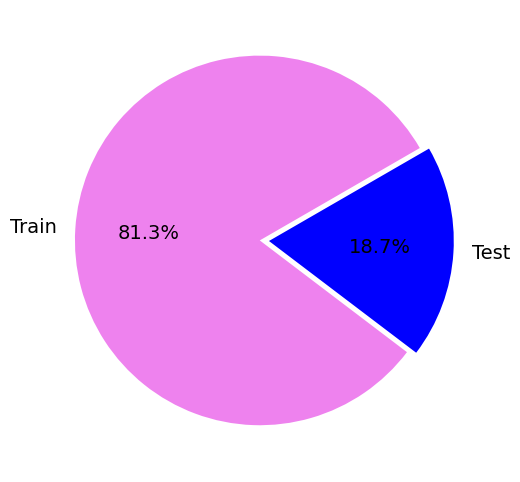

In [ ]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

### Porcentaje de datos por clase (balanceo de clases)

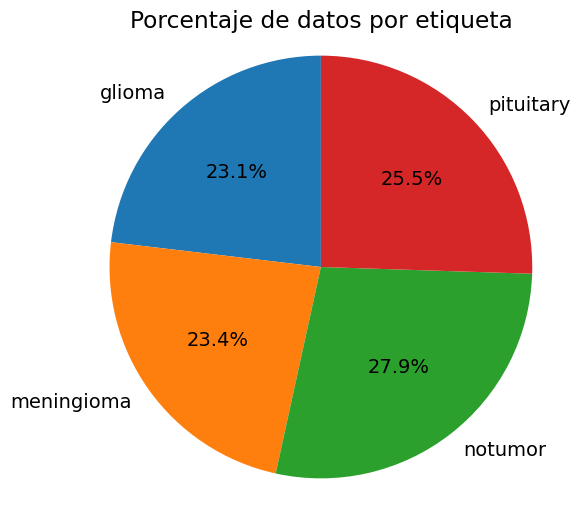

In [ ]:
# Obtener la cantidad de datos para cada etiqueta
label_counts = np.bincount(Y_train)

# Calcular los porcentajes de datos para cada etiqueta
label_percentages = label_counts / len(Y_train) * 100

# Etiquetas de las categorías
label_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Crear el gráfico de queso
plt.figure(figsize=(6, 6))
plt.pie(label_percentages, labels=label_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Para que el gráfico de queso sea circular
plt.title('Porcentaje de datos por etiqueta')
plt.show()

Se considera a raíz de los resultados del gráfico que el dataset esta balanceado.



### Visualización de las imágenes

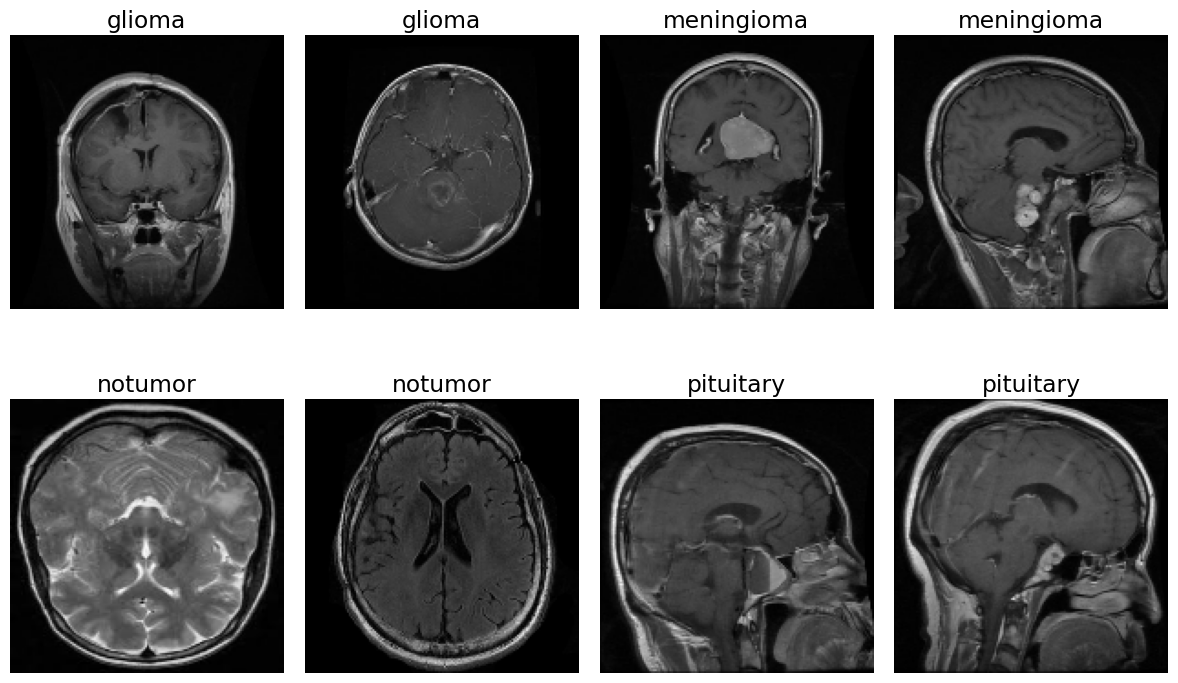

In [ ]:
# Función para obtener el nombre del tipo de tumor a partir del índice de etiqueta
def get_label_name(label):
    return labels[label]

# Función para mostrar las imágenes con sus etiquetas
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(get_label_name(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Seleccionar dos imágenes de cada tipo
num_samples = 2
selected_images = []
selected_labels = []
for label in range(len(labels)):
    label_indices = np.where(Y_train == label)[0]
    selected_indices = np.random.choice(label_indices, size=num_samples, replace=False)
    selected_images.extend(X_train[selected_indices])
    selected_labels.extend(Y_train[selected_indices])

# Mostrar las imágenes seleccionadas
show_images(selected_images, selected_labels)

Diferentes tipos de imagen en el dataset:

- No tumor: indica que esas imágenes no contienen un tumor.
- Meningioma: es un tipo de tumor que se desarrolla a partir de las membranas que rodean el cerebro y la médula espinal.
- Glioma: es un tipo de tumor que se desarrolla a partir de células gliales, que son células que brindan soporte y protección a las neuronas.
- Tumor pituitario: es un tipo de tumor que se desarrolla a partir de la glándula pituitaria, la cual se encuentra en la base del cerebro.

# **3. Creamos la red neuronal**

In [ ]:
# Definición de la red neuronal (10 capas)
def build_model():

 # Define the model architecture
    model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(150,150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(labels), activation="softmax")])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

### Definimos las métricas de evaluación del modelo, earlystopping y compile

In [ ]:
# Def Precision, Recall

# Early Stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor= 'val_loss', patience = 5)

# Model Compilation
from keras.optimizers import Adam
model.compile(loss= 'categorical_crossentropy', optimizer= Adam(learning_rate= 0.001),metrics=['accuracy', Precision(), Recall()])

### Entrenamiento de la red

In [ ]:
# Model Training
CNN = model.fit(X_train, Y_train_OHE, batch_size = 128, epochs= 50, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
41/41 [==============================] - 9s 103ms/step - loss: 7.1109 - accuracy: 0.5288 - precision: 0.5727 - recall: 0.3864 - val_loss: 0.7672 - val_accuracy: 0.6871 - val_precision: 0.7143 - val_recall: 0.6031
Epoch 2/50
41/41 [==============================] - 3s 76ms/step - loss: 0.6331 - accuracy: 0.7440 - precision: 0.7835 - recall: 0.6796 - val_loss: 0.5561 - val_accuracy: 0.7990 - val_precision: 0.8243 - val_recall: 0.7710
Epoch 3/50
41/41 [==============================] - 3s 77ms/step - loss: 0.4693 - accuracy: 0.8134 - precision: 0.8363 - recall: 0.7825 - val_loss: 0.4580 - val_accuracy: 0.8497 - val_precision: 0.8626 - val_recall: 0.8234
Epoch 4/50
41/41 [==============================] - 3s 76ms/step - loss: 0.3873 - accuracy: 0.8519 - precision: 0.8664 - recall: 0.8302 - val_loss: 0.4100 - val_accuracy: 0.8444 - val_precision: 0.8695 - val_recall: 0.8269
Epoch 5/50
41/41 [==============================] - 3s 74ms/step - loss: 0.3133 - accuracy: 0.8817 - precis

In [ ]:
# Guardar el modelo entrenado
save_model(model, '/content/drive/MyDrive/MasterUE/TFM/CNN_model.h5')

In [ ]:
# Cargar el modelo guardado
modelo_cargado = load_model("/content/drive/MyDrive/MasterUE/TFM/CNN_model.h5")

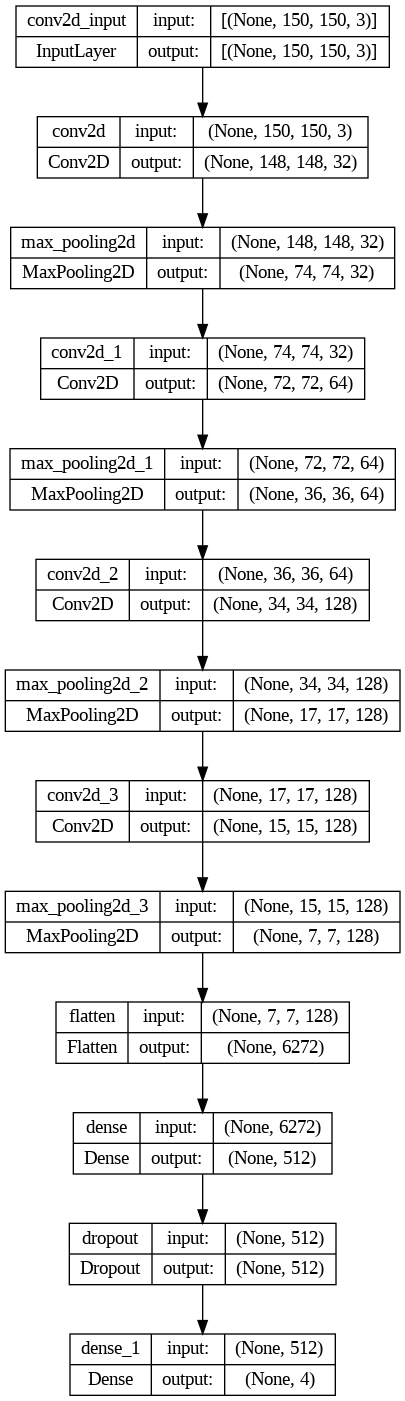

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Training accuracy vs Validation accuracy & Training loss vs Validation loss

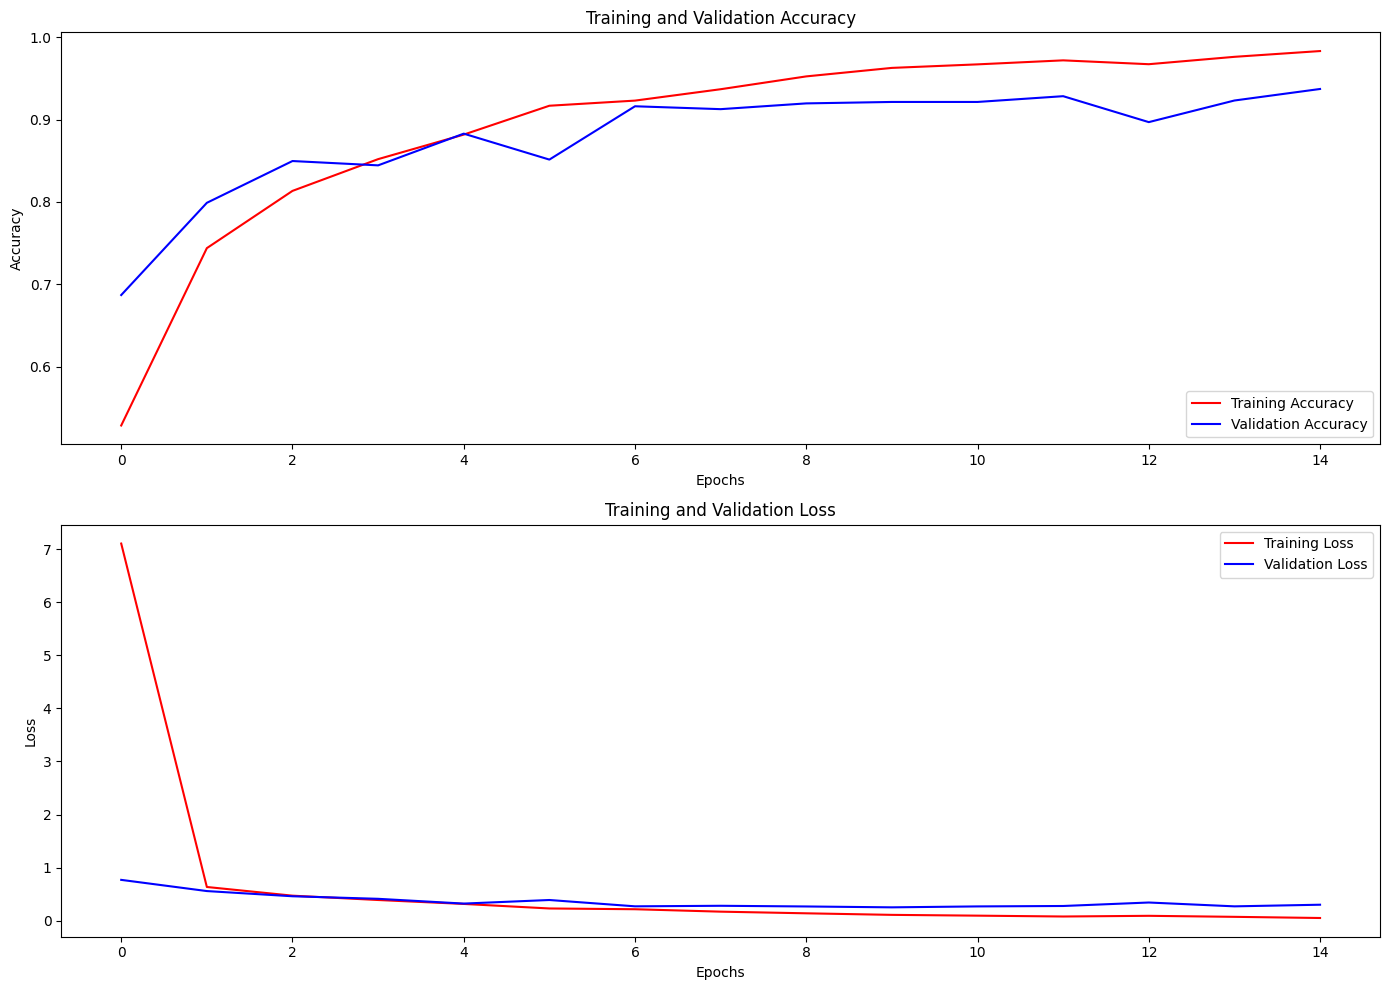

In [ ]:
acc_da = CNN.history['accuracy']
val_acc_da = CNN.history['val_accuracy']
loss_da = CNN.history['loss']
val_loss_da = CNN.history['val_loss']
epochs_da = range(len(acc_da))

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
ax1.plot(epochs_da, acc_da, 'r', label="Training Accuracy")
ax1.plot(epochs_da, val_acc_da, 'b', label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(epochs_da, loss_da, 'r', label="Training Loss")
ax2.plot(epochs_da, val_loss_da, 'b', label="Validation Loss")
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Evaluación de las métricas

#### Matriz de confusión

In [ ]:
# Aplicar el modelo CNN al conjunto de test
predictions = modelo_cargado.predict(X_test)

# Obtener las clases predichas (índice del valor máximo de cada predicción)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases reales del conjunto de prueba
true_classes = np.argmax(Y_test_OHE, axis=1)

41/41 [==============================] - 7s 12ms/step


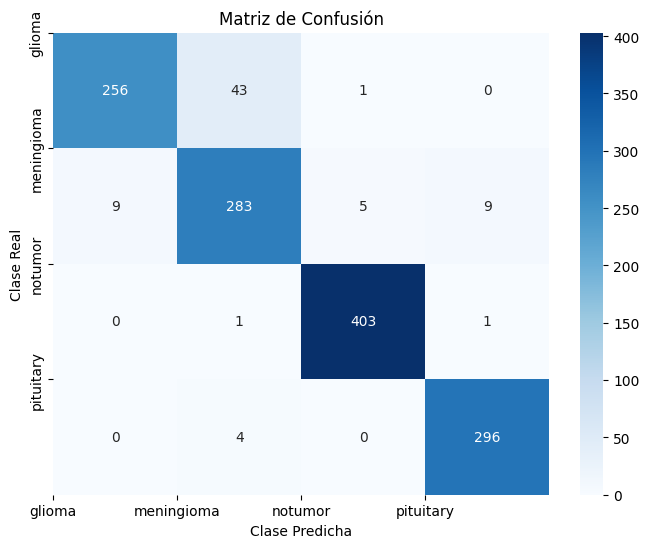

In [ ]:
# Obtener la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

In [ ]:
for i, label in enumerate(labels):
    TP = confusion[i, i]
    FP = np.sum(confusion[:, i]) - TP
    FN = np.sum(confusion[i, :]) - TP
    TN = np.sum(confusion) - TP - FP - FN

    print("Etiqueta:", label)
    print("Verdaderos Positivos (TP):", TP)
    print("Falsos Positivos (FP):", FP)
    print("Verdaderos Negativos (TN):", TN)
    print("Falsos Negativos (FN):", FN)
    print()

Etiqueta: glioma
Verdaderos Positivos (TP): 256
Falsos Positivos (FP): 9
Verdaderos Negativos (TN): 1002
Falsos Negativos (FN): 44

Etiqueta: meningioma
Verdaderos Positivos (TP): 283
Falsos Positivos (FP): 48
Verdaderos Negativos (TN): 957
Falsos Negativos (FN): 23

Etiqueta: notumor
Verdaderos Positivos (TP): 403
Falsos Positivos (FP): 6
Verdaderos Negativos (TN): 900
Falsos Negativos (FN): 2

Etiqueta: pituitary
Verdaderos Positivos (TP): 296
Falsos Positivos (FP): 10
Verdaderos Negativos (TN): 1001
Falsos Negativos (FN): 4



#### Visualización predicción de imágenes de test

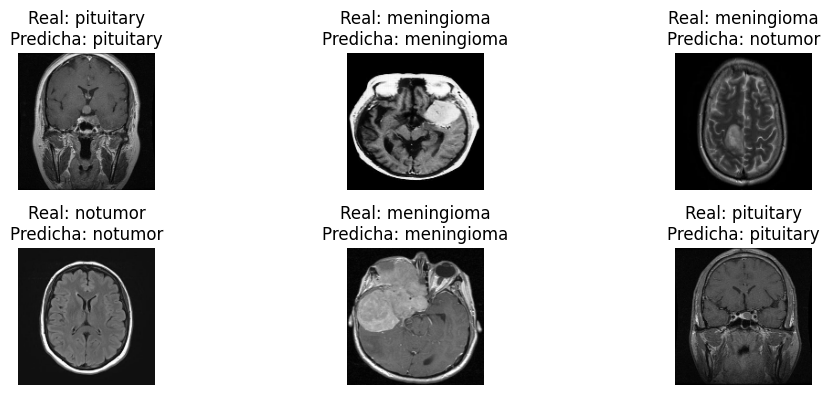

In [ ]:
# Crear una lista de índices aleatorios para seleccionar las imágenes de muestra
sample_indices = np.random.choice(len(X_test), size=6, replace=False)

# Obtener las imágenes de muestra, clases reales y clases predichas
sample_images = X_test[sample_indices]
sample_true_classes = true_classes[sample_indices]
sample_predicted_classes = predicted_classes[sample_indices]

# Configurar el tamaño de la figura y el espaciado entre las subfiguras
plt.figure(figsize=(10, 6))
plt.subplots_adjust(wspace=0.4)

# Mostrar las imágenes de muestra con la clase real y la clase predicha
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Real: {labels[sample_true_classes[i]]}\nPredicha: {labels[sample_predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Métricas del conjunto de test


In [ ]:
# Calcular el accuracy general del modelo
accuracy_general = accuracy_score(true_classes, predicted_classes)
print("Accuracy general del modelo:", accuracy_general)

Accuracy general del modelo: 0.9443173150266971


In [ ]:
# Classificacion report
print(classification_report(true_classes, predicted_classes, target_names=labels))

# Calcular el accuracy por clase ya que no viene dado explicitamente por classification report
accuracy_per_class = np.diag(confusion) / np.sum(confusion, axis=1)
for i, label in enumerate(labels):
    print(f"Accuracy para la clase {label}: {accuracy_per_class[i]}")

              precision    recall  f1-score   support

      glioma       0.97      0.85      0.91       300
  meningioma       0.85      0.92      0.89       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311

Accuracy para la clase glioma: 0.8533333333333334
Accuracy para la clase meningioma: 0.9248366013071896
Accuracy para la clase notumor: 0.9950617283950617
Accuracy para la clase pituitary: 0.9866666666666667


# **4. Data Augmentation**

In [ ]:
# Define image dimensions
img_height = 150
img_width = 150
batch_size = 128

# Define ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    # Data augmentation and rescaling parameters
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle = False)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


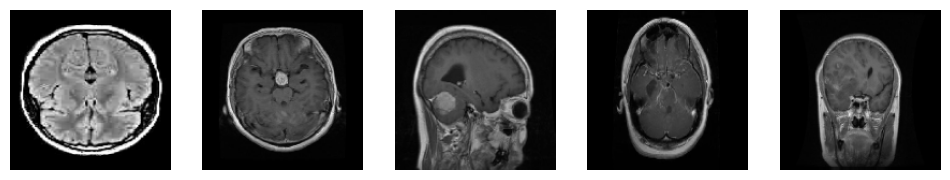

In [ ]:
# Generar 5 imágenes transformadas
transformed_images = []
for _ in range(5):
    # Redirigir la salida a un archivo temporal
    sys.stdout = open(os.devnull, 'w')
    batch = train_datagen.flow_from_directory(
        train_folder_path,
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=1
    )
    # Restaurar la salida estándar
    sys.stdout = sys.__stdout__
    transformed_images.append(batch[0][0][0])

# Mostrar las imágenes transformadas
plt.figure(figsize=(12, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(transformed_images[i])
    plt.axis('off')
plt.show()

In [ ]:
# Define los pasos por época y el número de épocas
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
epochs = 50

# Train the model
history = model.fit_generator(
    train_generator,
    workers = 8,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

<ipython-input-16-960b12984fb1>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
44/44 [==============================] - 58s 1s/step - loss: 1.0004 - accuracy: 0.5591 - precision: 0.7321 - recall: 0.3528 - val_loss: 0.7790 - val_accuracy: 0.7188 - val_precision: 0.7669 - val_recall: 0.6633
Epoch 2/50
44/44 [==============================] - 58s 1s/step - loss: 0.6772 - accuracy: 0.7219 - precision: 0.7826 - recall: 0.6465 - val_loss: 0.6189 - val_accuracy: 0.7484 - val_precision: 0.7706 - val_recall: 0.7086
Epoch 3/50
44/44 [==============================] - 61s 1s/step - loss: 0.5523 - accuracy: 0.7835 - precision: 0.8184 - recall: 0.7351 - val_loss: 0.7667 - val_accuracy: 0.7273 - val_precision: 0.7600 - val_recall: 0.6852
Epoch 4/50
44/44 [==============================] - 56s 1s/step - loss: 0.4837 - accuracy: 0.8023 - precision: 0.8320 - recall: 0.7692 - val_loss: 0.4822 - val_accuracy: 0.8031 - val_precision: 0.8265 - val_recall: 0.7742
Epoch 5/50
44/44 [==============================] - 63s 1s/step - loss: 0.4091 - accuracy: 0.8480 - precision: 0

In [ ]:
# Guardar el modelo entrenado
save_model(model, '/content/drive/MyDrive/MasterUE/TFM/CNN_DA_entrenada.h5')

In [ ]:
# Cargar el modelo guardado
modelo_cargado_DA = load_model("/content/drive/MyDrive/MasterUE/TFM/CNN_DA_entrenada.h5")

### Training accuracy vs Validation accuracy & Training loss vs Validation loss


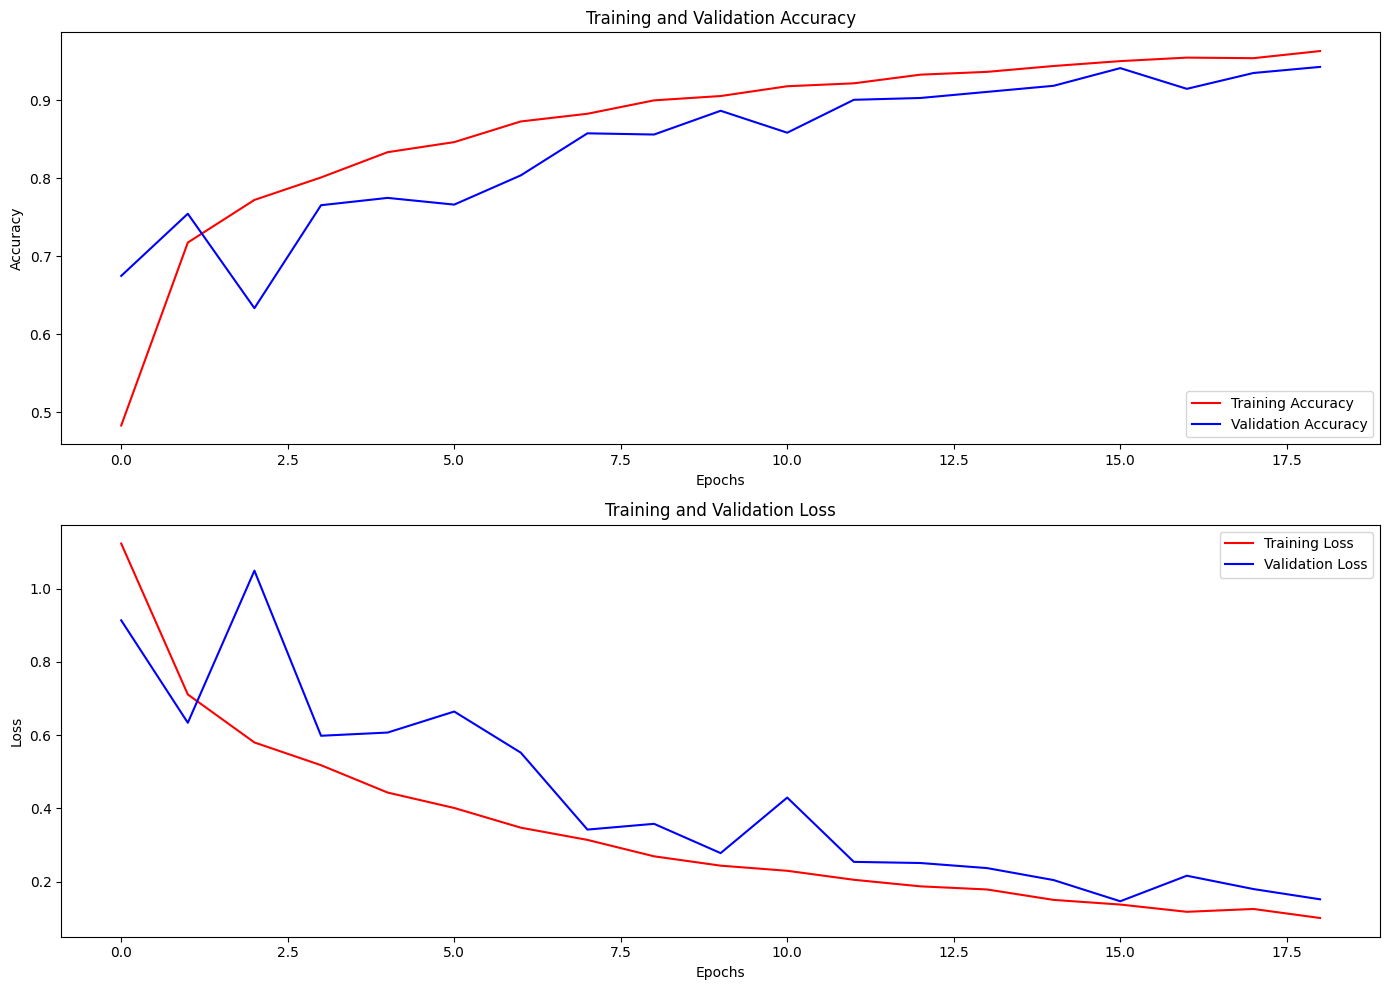

In [ ]:
acc_da = history.history['accuracy']
val_acc_da = history.history['val_accuracy']
loss_da = history.history['loss']
val_loss_da = history.history['val_loss']
epochs_da = range(len(acc_da))

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
ax1.plot(epochs_da, acc_da, 'r', label="Training Accuracy")
ax1.plot(epochs_da, val_acc_da, 'b', label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(epochs_da, loss_da, 'r', label="Training Loss")
ax2.plot(epochs_da, val_loss_da, 'b', label="Validation Loss")
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Evaluación de las métricas

#### Matriz de confusuón

In [ ]:
# Realizamos las predicciones en el conjunto de test
predictions = modelo_cargado_DA.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

11/11 [==============================] - 19s 592ms/step


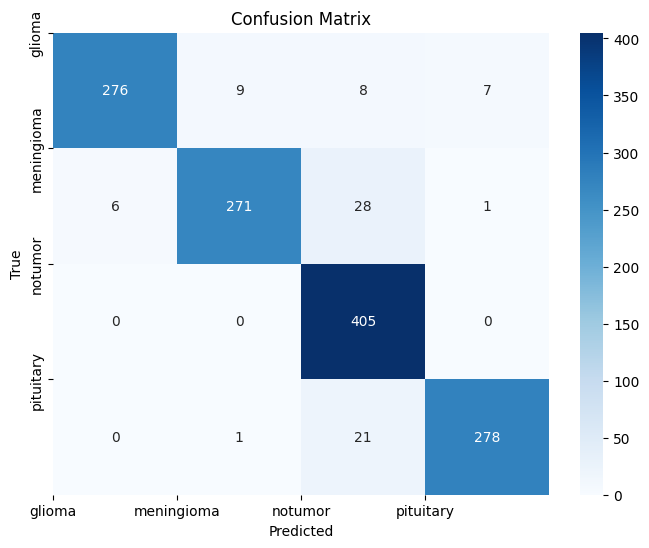

In [ ]:
# Creamos la matriz de confusión
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Ploteamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

In [ ]:
for i, label in enumerate(labels):
    TP = confusion_matrix[i, i].numpy()
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    TN = np.sum(confusion_matrix) - TP - FP - FN

    print("Etiqueta:", label)
    print("Verdaderos Positivos (TP):", TP)
    print("Falsos Positivos (FP):", FP)
    print("Verdaderos Negativos (TN):", TN)
    print("Falsos Negativos (FN):", FN)
    print()

Etiqueta: glioma
Verdaderos Positivos (TP): 276
Falsos Positivos (FP): 6
Verdaderos Negativos (TN): 1005
Falsos Negativos (FN): 24

Etiqueta: meningioma
Verdaderos Positivos (TP): 271
Falsos Positivos (FP): 10
Verdaderos Negativos (TN): 995
Falsos Negativos (FN): 35

Etiqueta: notumor
Verdaderos Positivos (TP): 405
Falsos Positivos (FP): 57
Verdaderos Negativos (TN): 849
Falsos Negativos (FN): 0

Etiqueta: pituitary
Verdaderos Positivos (TP): 278
Falsos Positivos (FP): 8
Verdaderos Negativos (TN): 1003
Falsos Negativos (FN): 22



#### Visualización predicción de imágenes de test

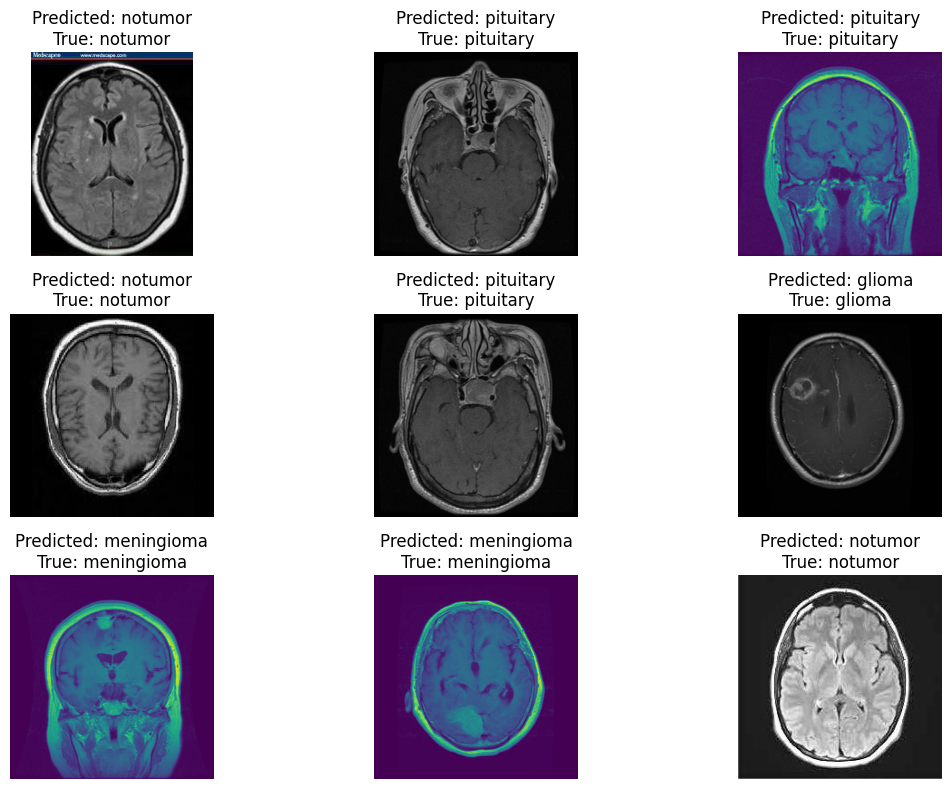

In [ ]:
# Mostrar las imágenes de muestra con la clase real y la clase predicha
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [labels[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [labels[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_folder_path, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

#### Métricas del conjunto de test

In [ ]:
# Calcular el accuracy general del modelo
accuracy_general = accuracy_score(true_categories, predicted_categories)
print("Accuracy general del modelo:", accuracy_general)

Accuracy general del modelo: 0.9382151029748284


In [ ]:
# Obtener las etiquetas verdaderas del conjunto de pruebas
y_true = test_generator.classes

# Calcular el classification report
class_report = classification_report(y_true, predicted_categories, target_names=labels)
print("Classification Report:")
print(class_report)

# Calcular el accuracy por clase ya que no viene dado explicitamente por classification report
accuracy_per_class_DA = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
for i, label in enumerate(labels):
    print(f"Accuracy para la clase {label}: {accuracy_per_class_DA[i]}")

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.96      0.89      0.92       306
     notumor       0.88      1.00      0.93       405
   pituitary       0.97      0.93      0.95       300

    accuracy                           0.94      1311
   macro avg       0.95      0.93      0.94      1311
weighted avg       0.94      0.94      0.94      1311

Accuracy para la clase glioma: 0.92
Accuracy para la clase meningioma: 0.8856209150326797
Accuracy para la clase notumor: 1.0
Accuracy para la clase pituitary: 0.9266666666666666


# **5. SVM**

- Probaremos el modelo aplicando HOG a las imágenes y sin aplicarlo.

## Sin aplicar HOG

In [ ]:
# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_flattened)
X_train_flattened = scaling.transform(X_train_flattened)
X_test_flattened = scaling.transform(X_test_flattened)

In [ ]:
# Create SVM classifier
svm_classifier = SVC()

In [ ]:
# Train SVM classifier
svm_classifier.fit(X_train_flattened, Y_train)

SVC()

In [ ]:
# Guardar el modelo
dump(svm_classifier, "/content/drive/MyDrive/MasterUE/TFM/svc_classifier_sin_hog.pkl")

['/content/drive/MyDrive/MasterUE/TFM/svc_classifier_sin_hog.pkl']

In [ ]:
# Cargar el clasificador SVM
svc_clf_cargado_sin_hog = joblib.load("/content/drive/MyDrive/MasterUE/TFM/svc_classifier_sin_hog.pkl")

### Evaluación de las métricas

#### Matriz de confusión

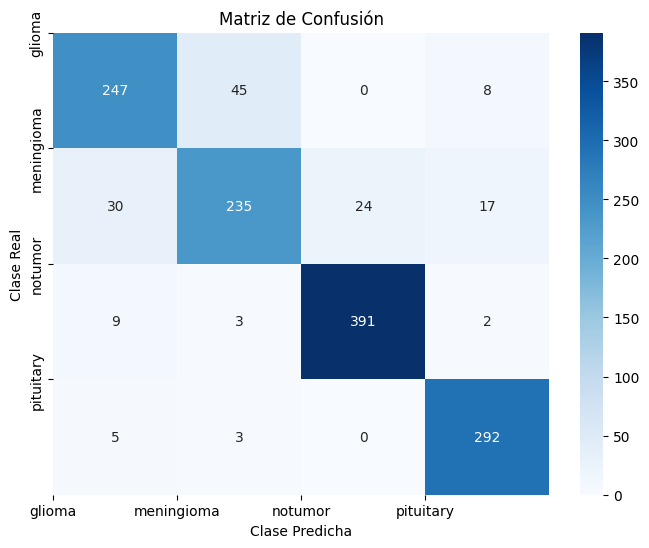

In [ ]:
#Calculamos las predicciones para el conjunto de test
test_predictions_svc = svc_clf_cargado_sin_hog.predict(X_test_flattened)

# Calculamos la matriz de confusión
test_confusion_matrix_SVC = tf.math.confusion_matrix(Y_test, test_predictions_svc)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_SVC, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

In [ ]:
for i, label in enumerate(labels):
    TP = test_confusion_matrix_SVC[i, i].numpy()
    FP = np.sum(test_confusion_matrix_SVC[:, i]) - TP
    FN = np.sum(test_confusion_matrix_SVC[i, :]) - TP
    TN = np.sum(test_confusion_matrix_SVC) - TP - FP - FN

    print("Etiqueta:", label)
    print("Verdaderos Positivos (TP):", TP)
    print("Falsos Positivos (FP):", FP)
    print("Verdaderos Negativos (TN):", TN)
    print("Falsos Negativos (FN):", FN)
    print()

Etiqueta: glioma
Verdaderos Positivos (TP): 247
Falsos Positivos (FP): 44
Verdaderos Negativos (TN): 967
Falsos Negativos (FN): 53

Etiqueta: meningioma
Verdaderos Positivos (TP): 235
Falsos Positivos (FP): 51
Verdaderos Negativos (TN): 954
Falsos Negativos (FN): 71

Etiqueta: notumor
Verdaderos Positivos (TP): 391
Falsos Positivos (FP): 24
Verdaderos Negativos (TN): 882
Falsos Negativos (FN): 14

Etiqueta: pituitary
Verdaderos Positivos (TP): 292
Falsos Positivos (FP): 27
Verdaderos Negativos (TN): 984
Falsos Negativos (FN): 8



#### Visualización predicción de imágenes de test

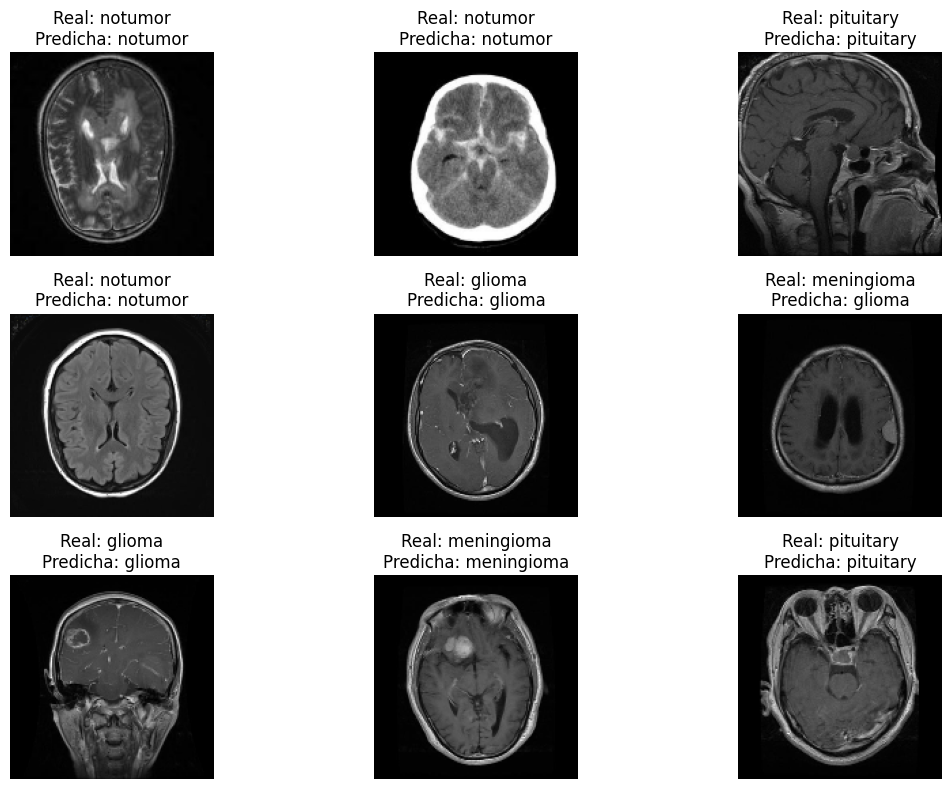

In [ ]:
# Obtener los índices de muestra
sample_indices = np.random.choice(range(len(X_test_flattened)), size=9, replace=False)

# Obtener las imágenes de muestra, las etiquetas reales y las etiquetas predichas
sample_images = X_test_flattened[sample_indices]
sample_true_labels = Y_test[sample_indices]
sample_predictions = test_predictions_svc[sample_indices]

# Mapear los índices de clase a las etiquetas de clase correspondientes
etiquetas_clase = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Mostrar las imágenes de muestra con las etiquetas reales y las etiquetas predichas
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = sample_images[i].reshape(150, 150, 3)  # Reemplaza `image_width` y `image_height` con las dimensiones reales de tus imágenes

    # Normalizar los valores de la matriz de la imagen
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img, cmap='gray')  # Usa el mapa de colores apropiado para tus imágenes
    plt.title(f"Real: {etiquetas_clase[sample_true_labels[i]]}\nPredicha: {etiquetas_clase[sample_predictions[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

#### Métricas del conjunto de test

In [ ]:
# Calcular el accuracy general del modelo
accuracy_general = accuracy_score(Y_test, test_predictions_svc)
print("Accuracy general del modelo:", accuracy_general)

Accuracy general del modelo: 0.8886346300533944


In [ ]:
# Classification report
test_classification_report = classification_report(Y_test, test_predictions_svc, target_names=labels)

print("Test Classification Report:")
print(test_classification_report)

# Calcular el accuracy por clase ya que no viene dado explicitamente por classification report
accuracy_per_class_svc = np.diag(test_confusion_matrix_SVC) / np.sum(test_confusion_matrix_SVC, axis=1)
for i, label in enumerate(labels):
    print(f"Accuracy para la clase {label}: {accuracy_per_class_svc[i]}")

Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.82      0.84       300
  meningioma       0.82      0.77      0.79       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.92      0.97      0.94       300

    accuracy                           0.89      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311

Accuracy para la clase glioma: 0.8233333333333334
Accuracy para la clase meningioma: 0.7679738562091504
Accuracy para la clase notumor: 0.9654320987654321
Accuracy para la clase pituitary: 0.9733333333333334


## Aplicando HOG

In [ ]:
class HoGExtractor():
  def __init__(self, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3)):
    self.orientations = orientations
    self.pixels_per_cell = pixels_per_cell
    self.cells_per_block = cells_per_block

  def set_params(self, **kwargs):
    self.orientations = kwargs.get('orientations', self.orientations)
    self.pixels_per_cell = kwargs.get('pixels_per_cell', self.pixels_per_cell)
    self.cells_per_block = kwargs.get('cells_per_block', self.cells_per_block)
    return self

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.array([hog(x, orientations = self.orientations, pixels_per_cell = self.pixels_per_cell,
                         cells_per_block = self.cells_per_block, visualize=False, channel_axis=None) for x in X])

In [ ]:
# Preprocesamiento de datos
X_train_gray = np.array([rgb2gray(x) for x in X_train])  # Conversión a escala de grises
X_test_gray = np.array([rgb2gray(x) for x in X_test])  # Conversión a escala de grises

In [ ]:
# Preprocesamiento de datos
X_train_gray = X_train_gray[::5,:,:]
X_test_gray = X_test_gray[::5,:,:]
Y_train_sub = Y_train[::5]
Y_test_sub = Y_test[::5]

In [ ]:
# Definición del clasificador
svc_clf = SVC()

# Definición del pipeline
pipe_SVM = Pipeline([
    ('hog', HoGExtractor()),
    ('svc', svc_clf)
    ])

# Definición de los parámetros a buscar en la cuadrícula
params_SVM = {
    'hog__orientations': [8, 10],
    'hog__pixels_per_cell': [(4, 4), (6, 6)],
    'hog__cells_per_block': [(1, 1), (3, 3)],
    'svc__class_weight': [None, 'balanced'],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01],
}

# definir el RandomizedSearch
grid_search_SVM = RandomizedSearchCV(pipe_SVM, params_SVM, n_iter=10, cv=2, scoring='accuracy', error_score='raise', n_jobs=1)

# fit the grid search to the data
grid_search_SVM.fit(X_train_gray, Y_train_sub)

# Imprime los mejores parámetros
print(grid_search_SVM.best_params_)

# Evalúa el modelo en el conjunto de prueba
print(grid_search_SVM.score(X_test_gray, Y_test_sub))

best_model = grid_search_SVM.best_estimator_
print(best_model.get_params())
print("Mejores hiperparámetros:")
print("class_weight:", best_model.named_steps['svc'].class_weight)
print("kernel:", best_model.named_steps['svc'].kernel)
print("C:", best_model.named_steps['svc'].C)
print("gamma:", best_model.named_steps['svc'].gamma)

Como el espacio de hiperparámetros es grande y complejo y los recursos computacionales son limitados, utilizaremos RandomizedSearchCV en lugar de GridSearchCV. Explora de manera eficiente el espacio de hiperparámetros seleccionando una muestra aleatoria de combinaciones para evaluar, lo que reduce el tiempo de ejecución en comparación con GridSearchCV. Sin embargo, es posible que los resultados no sean tan precisos ya que no se examinan todas las combinaciones.

In [ ]:
# Creación del extractor HOG con los mejores hiperparámetros
best_hog_params = grid_search_SVM.best_params_['hog__orientations'],
grid_search_SVM.best_params_['hog__pixels_per_cell'],
grid_search_SVM.best_params_['hog__cells_per_block']

hog_extractor = HoGExtractor(*best_hog_params)
# Guardar el extractor HOG
joblib.dump(hog_extractor, '/content/drive/MyDrive/MasterUE/TFM/hog_extractor_subset.pkl')

In [ ]:
# Cargar el extractor HOG
hog_extractor_cargado = joblib.load('/content/drive/MyDrive/MasterUE/TFM/hog_extractor_subset.pkl')
# Aplicar extracción de características HOG a X_train y X_test
X_train_hog = hog_extractor_cargado.transform(X_train_gray)
X_test_hog = hog_extractor_cargado.transform(X_test_gray)

In [ ]:
# Creación del clasificador SVM con los mejores hiperparámetros
best_svc_params = {k.replace('svc__', ''): v for k, v in grid_search_SVM.best_params_.items() if 'svc__' in k}
svc_clf = SVC(**best_svc_params)

# Entrenamiento del clasificador SVM en las características HOG
svc_clf.fit(X_train_hog, Y_train_sub)
# Guardar el clasificador SVM
joblib.dump(svc_clf, '/content/drive/MyDrive/MasterUE/TFM/svc_classifier_subset.pkl')

In [ ]:
# Cargar el clasificador SVM
svc_clf_cargado = joblib.load('/content/drive/MyDrive/MasterUE/TFM/svc_classifier_subset.pkl')

### Evaluación de las métricas

#### Matriz de confusión

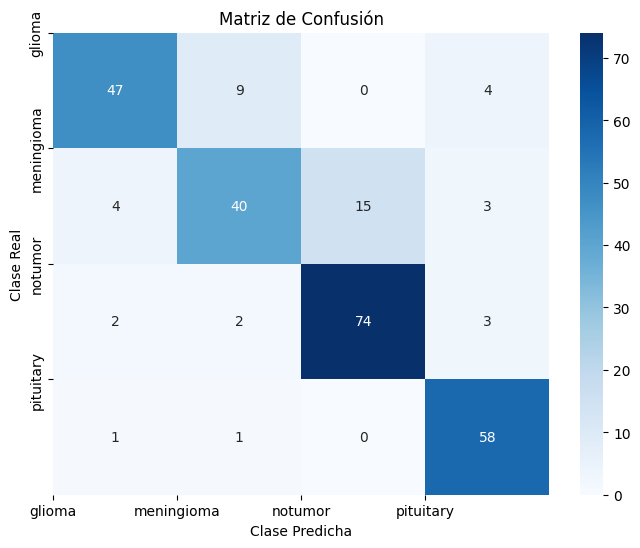

In [ ]:
# Calculamos las predicciones para el conjunto de test
test_predictions_HOG = svc_clf_cargado.predict(X_test_hog)

# Calculamos la matriz de onfusión
test_confusion_matrix_HOG = tf.math.confusion_matrix(Y_test_sub, test_predictions_HOG)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_HOG, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

In [ ]:
for i, label in enumerate(labels):
    TP = test_confusion_matrix_HOG[i, i].numpy()
    FP = np.sum(test_confusion_matrix_HOG[:, i]) - TP
    FN = np.sum(test_confusion_matrix_HOG[i, :]) - TP
    TN = np.sum(test_confusion_matrix_HOG) - TP - FP - FN

    print("Etiqueta:", label)
    print("Verdaderos Positivos (TP):", TP)
    print("Falsos Positivos (FP):", FP)
    print("Verdaderos Negativos (TN):", TN)
    print("Falsos Negativos (FN):", FN)
    print()

Etiqueta: glioma
Verdaderos Positivos (TP): 47
Falsos Positivos (FP): 7
Verdaderos Negativos (TN): 196
Falsos Negativos (FN): 13

Etiqueta: meningioma
Verdaderos Positivos (TP): 40
Falsos Positivos (FP): 12
Verdaderos Negativos (TN): 189
Falsos Negativos (FN): 22

Etiqueta: notumor
Verdaderos Positivos (TP): 74
Falsos Positivos (FP): 15
Verdaderos Negativos (TN): 167
Falsos Negativos (FN): 7

Etiqueta: pituitary
Verdaderos Positivos (TP): 58
Falsos Positivos (FP): 10
Verdaderos Negativos (TN): 193
Falsos Negativos (FN): 2



#### Métricas del conjunto de test

In [ ]:
# Calcular el accuracy general del modelo
accuracy_general = accuracy_score(Y_test_sub, test_predictions_HOG)
print("Accuracy general del modelo:", accuracy_general)

Accuracy general del modelo: 0.8326996197718631


In [ ]:
# Classification report
test_classification_report = classification_report(Y_test_sub, test_predictions_HOG,target_names=labels)

print("Test Classification Report:")
print(test_classification_report)

# Calcular el accuracy por clase ya que no viene dado explicitamente por classification report
accuracy_per_class_svc = np.diag(test_confusion_matrix_HOG) / np.sum(test_confusion_matrix_HOG, axis=1)
for i, label in enumerate(labels):
    print(f"Accuracy para la clase {label}: {accuracy_per_class_svc[i]}")

Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.78      0.82        60
  meningioma       0.77      0.65      0.70        62
     notumor       0.83      0.91      0.87        81
   pituitary       0.85      0.97      0.91        60

    accuracy                           0.83       263
   macro avg       0.83      0.83      0.83       263
weighted avg       0.83      0.83      0.83       263

Accuracy para la clase glioma: 0.7833333333333333
Accuracy para la clase meningioma: 0.6451612903225806
Accuracy para la clase notumor: 0.9135802469135802
Accuracy para la clase pituitary: 0.9666666666666667


# **6. Segmentación de tumores (Morphological Snakes)**

In [ ]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def morphologicalsnakes(img):

    # Morphological ACWE
    image = img_as_float(img)

    # Initial level set
    init_ls = checkerboard_level_set(image.shape, 6)
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_chan_vese(image, 150, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax = axes.flatten()

    ax[0].imshow(image, cmap="gray")
    ax[0].set_axis_off()
    ax[0].contour(ls, [0.5], colors='b')
    ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

    ax[1].imshow(ls, cmap="gray")
    ax[1].set_axis_off()
    contour = ax[1].contour(evolution[2], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 2")
    contour = ax[1].contour(evolution[7], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 7")
    contour = ax[1].contour(evolution[35], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 35")
    contour = ax[1].contour(evolution[-1], [0.5], colors='b')
    contour.collections[0].set_label("Iteration 150")
    ax[1].legend(loc="upper right")
    title = "Morphological ACWE evolution"
    ax[1].set_title(title, fontsize=12)

    # Create custom legend handles with corresponding colors
    legend_handles = [
        Line2D([0], [0], color='g', label='Iteration 2'),
        Line2D([0], [0], color='y', label='Iteration 7'),
        Line2D([0], [0], color='r', label='Iteration 35'),
        Line2D([0], [0], color='b', label='Iteration 150')
    ]
    ax[1].legend(handles=legend_handles, loc="upper right")

    # Morphological GAC
    image = img_as_float(img)
    gimage = inverse_gaussian_gradient(image)

    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.69,
                                               iter_callback=callback)

    ax[2].imshow(image, cmap="gray")
    ax[2].set_axis_off()
    ax[2].contour(ls, [0.5], colors='b')
    ax[2].set_title("Morphological GAC segmentation", fontsize=12)

    ax[3].imshow(ls, cmap="gray")
    ax[3].set_axis_off()
    contour = ax[3].contour(evolution[0], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 0")
    contour = ax[3].contour(evolution[100], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 100")
    contour = ax[3].contour(evolution[230], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 230")
    contour = ax[3].contour(evolution[-1], [0.5], colors='b')
    contour.collections[0].set_label("Iteration 500")
    ax[3].legend(loc="upper right")
    title = "Morphological GAC evolution"
    ax[3].set_title(title, fontsize=12)

    # Create custom legend handles with corresponding colors
    legend_handles = [
        Line2D([0], [0], color='g', label='Iteration 0'),
        Line2D([0], [0], color='y', label='Iteration 100'),
        Line2D([0], [0], color='r', label='Iteration 230'),
        Line2D([0], [0], color='b', label='Iteration 500')
    ]
    ax[3].legend(handles=legend_handles, loc="upper right")
    fig.tight_layout()
    plt.show()


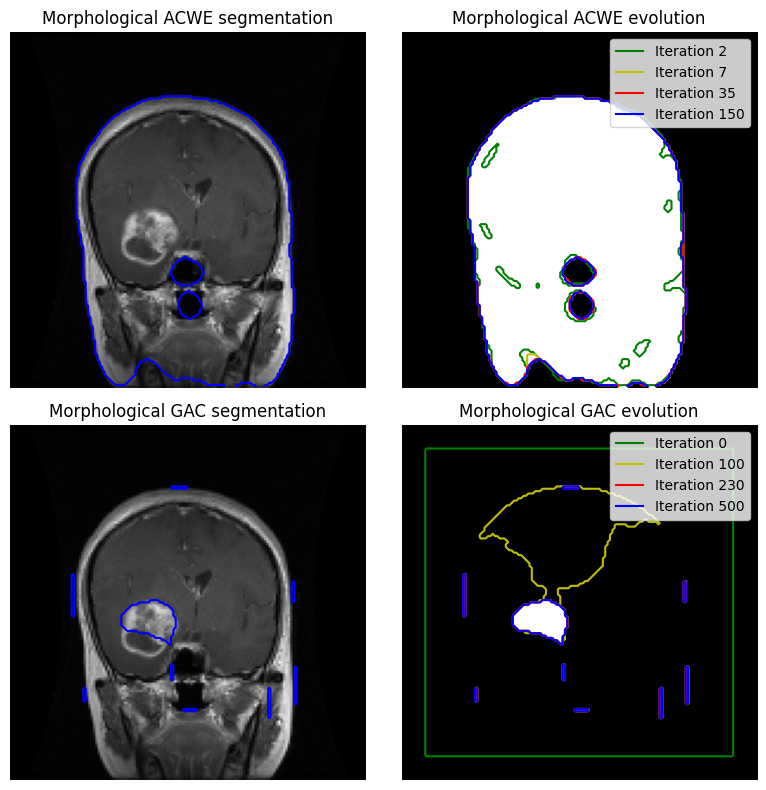

Gráfica 1: Clase glioma


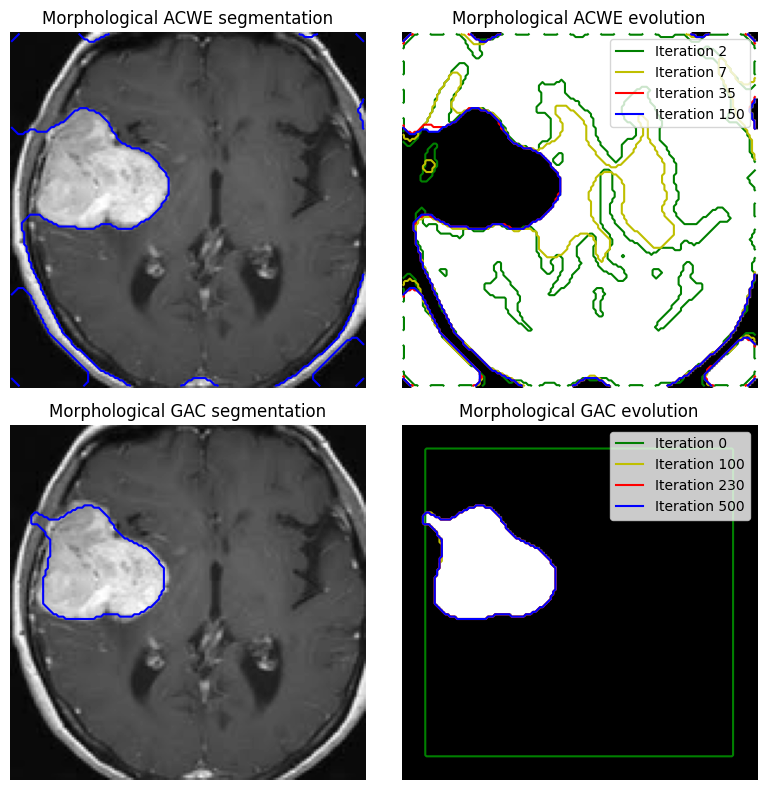

Gráfica 2: Clase meningioma


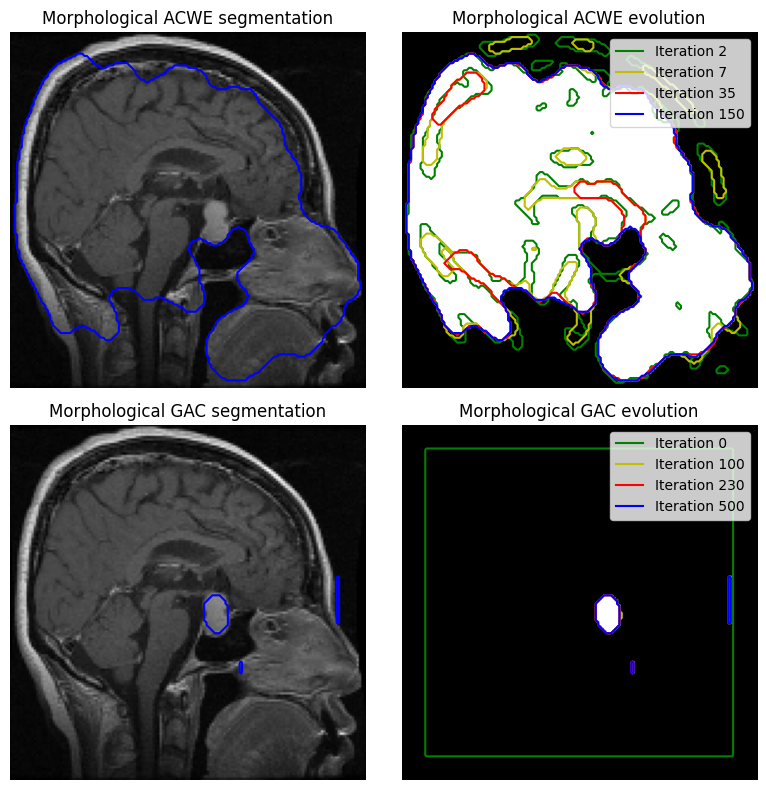

Gráfica 3: Clase pituitary


In [ ]:
# Obtener una imagen de glioma, una de meningioma y una de pituitary
glioma_img = X_train[Y_train == 0][9]
meningioma_img = X_train[Y_train == 1][5]
pituitary_img = X_train[Y_train == 3][400]

# Convertir las imágenes a escala de grises
glioma_gray = rgb2gray(glioma_img)
meningioma_gray = rgb2gray(meningioma_img)
pituitary_gray = rgb2gray(pituitary_img)

# Aplicar el algoritmo de morphological snakes a las imágenes en escala de grises
morphologicalsnakes(glioma_gray)
print("Gráfica 1: Clase glioma")
morphologicalsnakes(meningioma_gray)
print("Gráfica 2: Clase meningioma")
morphologicalsnakes(pituitary_gray)
print("Gráfica 3: Clase pituitary")